# Rotary Positional Encodings (RoPE)

In today's notebook, we'll be focusing on RoPE!

> NOTE: Check the paper [here](https://arxiv.org/pdf/2104.09864)

In [ ]:
!pip install -qU torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
!pip install -qU flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 🤝 BREAKOUT ROOM #1:

# The Building Block Fundamentals of Transformer Architecture

We're going to start with an example of an encoder-decoder model - the kind found in the classic paper:

[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf).

We'll walk through each step in code - leveraging the [PyTorch]() library heavily - in order to get an idea of how these models work.

While this example notebook could be extended to a sincere usecase - we'll be using a toy dataset, and we will not fully train the model until it converges (under-train), as the full training process might take many days!

## The Desired Architecture

![image](https://i.imgur.com/Od5LhSM.png)

We'll skip over the diagram for now, and talk through each component in detail!

In [ ]:
import torch
import torch.nn as nn
import math
from typing import Optional
from dataclasses import dataclass
from enum import Enum

## Embedding

![image](https://i.imgur.com/zJepUWV.png)

The first step will be do convert our tokenized sequence of inputs into an embedding vector. This allows use to understand a rich amount of information about input sequences and their semantic meanings.

As the embedding layer will be training along side the rest of the model - it will allow us to have an excellent vector-representation of the tokens in our dataset.

Let's see how it looks in code!

In [ ]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model: int, vocab_size: int, verbose=False) -> None:
    """
    vocab_size - the size of our vocabulary
    d_model - the dimension of our embeddings and the input dimension for our model
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.verbose = verbose

  def forward(self, x):
    if self.verbose:
      print(f"Embedding Vector (1st 5 elements): {self.embedding(x)[:5] * math.sqrt(self.d_model)}")
    return self.embedding(x) * math.sqrt(self.d_model) # scale embeddings by square root of d_model

### Test Embedding Layer

We'll set up a sample Embedding Layer and then test that it does what we'd expect!

In [ ]:
def test_input_embeddings_with_example():
    # Create a small embedding layer
    embed = InputEmbeddings(d_model=512, vocab_size=1000)

    # Example sentence tokens (simplified)
    tokens = torch.tensor([[1, 2, 3, 4, 5]])  # "The cat sat down quickly"

    output = embed(tokens)
    print(f"Input shape: {tokens.shape}")
    print(f"Output shape: {output.shape}")
    print("\nExample shows how words are converted to high-dimensional vectors")

    # Run technical test
    assert output.shape == (1, 5, 512), f"Expected shape (1, 5, 512), got {output.shape}"
    print("✓ Input Embeddings Test Passed")

In [ ]:
test_input_embeddings_with_example()

Input shape: torch.Size([1, 5])
Output shape: torch.Size([1, 5, 512])

Example shows how words are converted to high-dimensional vectors
✓ Input Embeddings Test Passed


## Positional Encoding

![image](https://i.imgur.com/cz6TTNn.png)

We need to impart information about where each token is in the sequence, but we aren't using any recurrence or convolutions - the easiest way to encode positional information is to inject positional information into our input embeddings.

We're going to use the process outlined in the paper to do this - which is to use a specific combination of functions to add positional information to the embeddings.

In [ ]:
class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float = 0.1, base: int = 10000) -> None:
        """
        Implements Rotary Position Embedding (RoPE).

        Args:
            d_model: Dimension of the model/embeddings
            seq_len: Maximum sequence length
            dropout: Dropout rate
            base: Base for the angular frequencies
        """
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        self.base = base

        # Only need half the dimensions since we'll create complex rotations
        assert d_model % 2 == 0, "Model dimension must be even for RoPE"

        # Create position-dependent rotation angles
        self.register_buffer(
            "inv_freq",
            1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
        )

    def _get_rotation_matrix(self, position: torch.Tensor) -> torch.Tensor:
        """Creates rotation matrices for the given positions."""
        position = position.unsqueeze(-1)
        angles = position * self.inv_freq
        cos = torch.cos(angles)
        sin = torch.sin(angles)
        return cos, sin

    def _rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        """Rotates half of the hidden dimensions of the input."""
        x1, x2 = x[..., ::2], x[..., 1::2]
        return torch.cat((-x2, x1), dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply rotary position embeddings to input tensor.

        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model]

        Returns:
            Tensor with rotary position embeddings applied
        """
        positions = torch.arange(x.size(1), device=x.device)
        cos, sin = self._get_rotation_matrix(positions)

        # Reshape for broadcasting
        cos = cos.view(1, x.size(1), 1, x.size(-1) // 2).repeat(x.size(0), 1, 1, 1)
        sin = sin.view(1, x.size(1), 1, x.size(-1) // 2).repeat(x.size(0), 1, 1, 1)

        # Reshape input for rotation
        x_reshape = x.view(x.size(0), x.size(1), -1, x.size(-1))

        # Apply rotation using complex multiplication
        x_out = torch.cat([
            cos * x_reshape[..., ::2] - sin * x_reshape[..., 1::2],
            cos * x_reshape[..., 1::2] + sin * x_reshape[..., ::2]
        ], dim=-1)

        # Restore original shape
        x_out = x_out.view(x.size())

        return self.dropout(x_out)

    def get_rotary_embeddings(self, x: torch.Tensor, offset: int = 0) -> torch.Tensor:
        """
        Get rotary embeddings for input tensor, with optional position offset.
        Useful for sliding window attention or inference.

        Args:
            x: Input tensor
            offset: Position offset to start from

        Returns:
            Rotary embeddings tensor
        """
        positions = torch.arange(x.size(1), device=x.device) + offset
        cos, sin = self._get_rotation_matrix(positions)
        return cos.view(1, -1, 1, x.size(-1) // 2), sin.view(1, -1, 1, x.size(-1) // 2)

## Add & Norm

Next we'll tackle the Add & Norm Block of the diagram.

![image](https://i.imgur.com/CLB2BVS.png)

### Layer Normalization

The first step is to add layer normalization. You can read more about it [here](https://paperswithcode.com/method/layer-normalization)!

The basic idea is that it makes training the model a bit easier, and allows the model to generalize a bit better.

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, features: int, epsilon:float=10**-6) -> None:
    super().__init__()
    self.epsilon = epsilon
    self.gamma = nn.Parameter(torch.ones(features))
    self.beta = nn.Parameter(torch.zeros(features))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    standard_deviation = x.std(dim = -1, keepdim = True)
    return self.gamma * (x - mean) / (standard_deviation + self.epsilon) + self.beta

### Test Layer Normalization

We'll set up a sample Layer Normalization and then test that it does what we'd expect!

In [ ]:
def test_layer_normalization_with_example():
    layer_norm = LayerNormalization(features=3)  # Smaller feature size for example

    # Simulate word embeddings with different magnitudes
    word_embeddings = torch.tensor([
        [2.5, 4.1, -3.2],  # "The" (high magnitude)
        [0.1, 0.2, -0.1],  # "cat" (low magnitude)
        [8.2, -6.1, 5.5]   # "sat" (very high magnitude)
    ]).unsqueeze(0)

    normalized = layer_norm(word_embeddings)

    print("Before normalization (magnitudes vary greatly):")
    print(word_embeddings[0])
    print("\nAfter normalization (values scaled to similar ranges):")
    print(normalized[0])

    # Verify statistical properties
    mean = normalized.mean(dim=-1)
    var = normalized.var(dim=-1)
    assert torch.allclose(mean, torch.zeros_like(mean), atol=1e-5)
    assert torch.allclose(var, torch.ones_like(var), atol=1e-5)
    print("✓ Layer Normalization Test Passed")

In [ ]:
test_layer_normalization_with_example()

Before normalization (magnitudes vary greatly):
tensor([[ 2.5000,  4.1000, -3.2000],
        [ 0.1000,  0.2000, -0.1000],
        [ 8.2000, -6.1000,  5.5000]])

After normalization (values scaled to similar ranges):
tensor([[ 0.3562,  0.7732, -1.1293],
        [ 0.2182,  0.8729, -1.0911],
        [ 0.7459, -1.1363,  0.3905]], grad_fn=<SelectBackward0>)
✓ Layer Normalization Test Passed


### Residual Connection

Another technique that makes model training easier, we add a Residual connection to the outputs of the Attention Block - this helps to prevent vanishing gradient.

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, features: int, dropout: float = 0.1) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.layernorm = LayerNormalization(features)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.layernorm(x)))

### Testing Residual Connection

We'll set up a sample Residual Connection and then test that it does what we'd expect!

In [ ]:
def test_residual_connection_with_example():
    residual = ResidualConnection(features=3, dropout=0.1)

    # Original input "The cat"
    x = torch.tensor([
        [1.0, 1.0, 1.0],
        [2.0, 2.0, 2.0]
    ]).unsqueeze(0)

    # Sublayer that makes meaningful changes
    def sublayer(x):
        return torch.nn.functional.relu(x + 0.5) # Non-linear transformation

    output = residual(x, sublayer)

    print("Original input:")
    print(x[0])
    print("\nAfter residual connection (combines original + transformed):")
    print(output[0])

    # Verify output changed but maintained shape
    assert output.shape == x.shape
    assert torch.any(torch.abs(output - x) > 1e-6), "Output should differ from input"
    print("✓ Residual Connection Test Passed")

In [ ]:
test_residual_connection_with_example()

Original input:
tensor([[1., 1., 1.],
        [2., 2., 2.]])

After residual connection (combines original + transformed):
tensor([[1.5556, 1.5556, 1.5556],
        [2.0000, 2.5556, 2.5556]], grad_fn=<SelectBackward0>)
✓ Residual Connection Test Passed


## Feed Forward Network

![image](https://i.imgur.com/y2jdmNx.png)

Moving onto the next component, we have our feed forward network.

The feed forward networks servers two purposes in our model:

1. It reforms the attention outputs into a format that works with the next block.

2. It helps add complexity to prevent each attention block acting in a similar fashion.

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff: int = 2048, dropout: float = 0.1) -> None:
    """
    d_model - dimension of model
    d_ff - dimension of feed forward network
    dropout - regularization measure
    """
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

### Testing the Feed-forward Block

Let's test!

In [ ]:
def test_feed_forward_block_with_example():
   ff_block = FeedForwardBlock(d_model=3, d_ff=8)  # Small dimensions for demonstration

   # Input: Word embeddings for "The cat"
   x = torch.tensor([
       [1.0, 0.5, 0.2],  # "The"
       [2.0, -0.3, 1.1]  # "cat"
   ]).unsqueeze(0)

   output = ff_block(x)

   print("Input embeddings:")
   print(x[0])
   print("\nAfter feed-forward transformation:")
   print(output[0])

   # First linear layer expands to d_ff dimensions
   # ReLU keeps only positive values
   # Second linear layer projects back to d_model dimensions
   assert output.shape == x.shape
   assert not torch.allclose(output, x)
   print("✓ Feed Forward Block Test Passed")

In [ ]:
test_feed_forward_block_with_example()

Input embeddings:
tensor([[ 1.0000,  0.5000,  0.2000],
        [ 2.0000, -0.3000,  1.1000]])

After feed-forward transformation:
tensor([[-0.0642,  0.3999,  0.1095],
        [-0.1528,  0.4453,  0.0139]], grad_fn=<SelectBackward0>)
✓ Feed Forward Block Test Passed


## Task #1: Multi-Head Attention

![image](https://i.imgur.com/9c5dioJ.png)

Next up is the heart and soul of the Transformer - Multi-Head Attention.

We'll break it down into the basic building blocks in code in the following section!

### Task 2: Multi-Head Attention Class



In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int = 512, num_heads: int = 8, dropout: float = 0.1) -> None:
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    assert d_model % num_heads == 0, "d_model is not divisible by h"

    self.d_k = d_model // num_heads

    self.w_q = nn.Linear(d_model, d_model, bias=False)
    self.w_k = nn.Linear(d_model, d_model, bias=False)
    self.w_v = nn.Linear(d_model, d_model, bias=False)

    self.w_o = nn.Linear(d_model, d_model, bias=False)

    self.dropout = nn.Dropout(dropout)

### 👪❓Discussion Question 1:

Describe, in your own words, intuitively what each of `Q`, `K`, and `V` represent - beyond their names and functions.

Discuss among your group!

There is no single correct answer - and if you get stuck - feel free to ask your favourite Large Language Model!

### Testing Multi-Head Attention

Let's test it out!

### Task #3: Scaled Dot-Product Attention

![image](https://i.imgur.com/Yp48DuB.png)

In [ ]:
def attention(query, key, value, mask, d_k, dropout: nn.Dropout = None):
  attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

  if mask is not None:
    attention_scores.masked_fill_(mask == 0, -1e9)

  attention_scores = attention_scores.softmax(dim=-1)

  if dropout is not None:
    attention_scores = dropout(attention_scores)

  return (attention_scores @ value), attention_scores

### ❓Question 1:

Describe the above code that defines the attension mechanism.

Write, in natural language, what each step is doing.

### Task #4: Forward Method

This is code is required to do a forward pass with our model.

In [ ]:
def forward(self, query, key, value, mask):
  query = self.w_q(query)
  key = self.w_k(key)
  value = self.w_v(value)

  query = query.view(query.shape[0], query.shape[1], self.num_heads, self.d_k).transpose(1, 2)
  key = key.view(key.shape[0], key.shape[1], self.num_heads, self.d_k).transpose(1, 2)
  value = value.view(value.shape[0], value.shape[1], self.num_heads, self.d_k).transpose(1, 2)

  x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

  x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.num_heads * self.d_k)

  return self.w_o(x)

### Task #4: Combining it All Together - and Introducing Flash Attention

We'll start with implementing a simple set of `configs` - and then get straight into an Attention implementation!

In [ ]:
class AttentionType(Enum):
    REGULAR = "regular"
    FLASH = "flash"

@dataclass
class AttentionConfig:
    attention_type: AttentionType
    d_model: int = 512
    num_heads: int = 8
    dropout: float = 0.1
    rotary_dim: int = None

All we need to do is tie together the above steps into one big block!

In [ ]:
class ModularAttentionWithRoPE(nn.Module):
    def __init__(self, config: AttentionConfig):
        super().__init__()
        self.config = config
        self.d_model = config.d_model
        self.num_heads = config.num_heads
        self.d_k = config.d_model // config.num_heads

        # Linear projections
        self.w_q = nn.Linear(config.d_model, config.d_model, bias=False)
        self.w_k = nn.Linear(config.d_model, config.d_model, bias=False)
        self.w_v = nn.Linear(config.d_model, config.d_model, bias=False)
        self.w_o = nn.Linear(config.d_model, config.d_model, bias=False)

        self.dropout = config.dropout

        # Store attention scores
        self.attention_scores = None

        # RoPE embedding
        self.rope = RotaryPositionalEncoding(
            d_model=self.d_k,
            seq_len=2048
        )

    def _apply_rotary_pos_emb(self, q: torch.Tensor, k: torch.Tensor) -> tuple:
        q_rot = self.rope(q)
        k_rot = self.rope(k)
        return q_rot, k_rot

    def _regular_attention(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor,
                         mask: Optional[torch.Tensor]) -> torch.Tensor:
        q, k = self._apply_rotary_pos_emb(q, k)

        d_k = q.shape[-1]
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)

        # Store the attention scores
        self.attention_scores = attention_weights.detach()

        if self.training:
            attention_weights = torch.dropout(attention_weights, self.dropout, self.training)

        return attention_weights @ v

    def _flash_attention(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor,
                        mask: Optional[torch.Tensor]) -> torch.Tensor:
        try:
            from flash_attn import flash_attn_func

            q, k = self._apply_rotary_pos_emb(q, k)

            if not all(x.dtype == torch.float16 for x in [q, k, v]):
                return self._regular_attention(q, k, v, mask)

            if not all(x.is_cuda for x in [q, k, v]):
                return self._regular_attention(q, k, v, mask)

            if mask is not None:
                mask = mask.to(dtype=torch.float32)

            dropout_p = self.dropout if self.training else 0.0
            q, k, v = q.contiguous(), k.contiguous(), v.contiguous()

            # Flash attention doesn't give us access to attention scores directly
            # So we'll compute them separately for visualization
            with torch.no_grad():
                scores = (q @ k.transpose(-2, -1)) / math.sqrt(q.size(-1))
                self.attention_scores = torch.softmax(scores, dim=-1).detach()

            return flash_attn_func(
                q, k, v,
                dropout_p=dropout_p,
                causal=False,
                softmax_scale=None
            )

        except ImportError:
            return self._regular_attention(q, k, v, mask)
        except Exception as e:
            return self._regular_attention(q, k, v, mask)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size = query.shape[0]

        # Linear projections and reshape
        q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        q, k, v = q.contiguous(), k.contiguous(), v.contiguous()

        if self.config.attention_type == AttentionType.FLASH:
            attn_output = self._flash_attention(q, k, v, mask)
        else:
            attn_output = self._regular_attention(q, k, v, mask)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.w_o(attn_output)

    def get_attention_scores(self) -> Optional[torch.Tensor]:
        """Returns the attention scores from the last forward pass"""
        return self.attention_scores

#### 👪❓Discussion Question 2:

Work with your breakout room to build a visualization of the above `forward` pass - including dummy inputs.

You can use drawing programs (like [Excalidraw](https://excalidraw.com/)), or write a visualization in code.

> NOTE: LLMs like Claude 3.5 Sonnet is a fantastic tool to produce (and test) visualizations in it's [Web UI](https://claude.ai/new)!

### Testing MultiHeadAttention

Let's test it out!

In [ ]:
def test_attention_mechanisms():
    attention_configs = [
        AttentionConfig(attention_type=AttentionType.REGULAR, d_model=6, num_heads=2, dropout=0.1),
        AttentionConfig(attention_type=AttentionType.FLASH, d_model=6, num_heads=2, dropout=0.1)
    ]

    # Create sequence in float16
    seq = torch.tensor([
        [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
    ], dtype=torch.float16).unsqueeze(0).cuda()

    mask = None

    for config in attention_configs:
        try:
            print(f"\nTesting {config.attention_type.value} attention:")
            print("-" * 50)

            mha = ModularAttentionWithRoPE(config).cuda().half()

            # Convert model weights to float16
            for param in mha.parameters():
                param.data = param.data.half()

            output = mha(seq, seq, seq, mask)

            print(f"Input shape: {seq.shape}")
            print("Input values:")
            print(seq[0])
            print("\nOutput values:")
            print(output[0])

            assert output.shape == seq.shape
            assert not torch.allclose(output, seq)
            print(f"✓ {config.attention_type.value.title()} Attention Test Passed")

        except ImportError:
            print(f"Flash Attention not available, skipping {config.attention_type.value} test")
        except Exception as e:
            print(f"Error testing {config.attention_type.value} attention: {str(e)}")

        # Cleanup to prevent CUDA memory issues
        torch.cuda.empty_cache()

In [ ]:
test_attention_mechanisms()


Testing regular attention:
--------------------------------------------------
Input shape: torch.Size([1, 3, 6])
Input values:
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.]], device='cuda:0', dtype=torch.float16)

Output values:
tensor([[-0.2059,  0.0512,  0.3945,  0.4014, -0.1779, -0.0786],
        [-0.1819, -0.0387,  0.2798,  0.2803, -0.0506, -0.1565],
        [-0.2034,  0.0331,  0.3730,  0.3789, -0.1537, -0.0837]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
✓ Regular Attention Test Passed

Testing flash attention:
--------------------------------------------------
Input shape: torch.Size([1, 3, 6])
Input values:
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.]], device='cuda:0', dtype=torch.float16)

Output values:
tensor([[ 0.2949,  0.3127,  0.0592, -0.0163, -0.3589, -0.1509],
        [-0.0501, -0.0475,  0.1141, -0.0030,  0.0639, -0.1714],
       

In [ ]:
class TransformerBlockWithRoPE(nn.Module):
    def __init__(self,
                 features: int,
                 attn_config: AttentionConfig,
                 feed_forward: nn.Module,
                 dropout: float,
                 is_decoder: bool = False):
        super().__init__()
        self.is_decoder = is_decoder
        self.self_attention = ModularAttentionWithRoPE(attn_config)
        self.feed_forward = feed_forward

        num_connections = 3 if is_decoder else 2
        self.residual_connections = nn.ModuleList([
            ResidualConnection(features, dropout) for _ in range(num_connections)
        ])

        if is_decoder:
            self.cross_attention = ModularAttentionWithRoPE(attn_config)

    def forward(self, x: torch.Tensor,
                encoder_output: Optional[torch.Tensor] = None,
                self_mask: Optional[torch.Tensor] = None,
                cross_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.residual_connections[0](x, lambda x: self.self_attention(x, x, x, self_mask))

        if self.is_decoder:
            if encoder_output is None:
                raise ValueError("Decoder block requires encoder_output")
            x = self.residual_connections[1](x, lambda x: self.cross_attention(x, encoder_output, encoder_output, cross_mask))
            return self.residual_connections[2](x, self.feed_forward)

        return self.residual_connections[1](x, self.feed_forward)

## Encoder

When we pass information through our model - the first thing we will do is Encode it by passing it through our Encoder Blocks.


### Encoder Block

![image](https://i.imgur.com/BkM8lxV.png)

The encoder takes in the source language sentence (e.g. English). Each word is converted into a vector representation using an embedding layer. Then a positional encoder adds information about the position of each word. This goes through multiple self-attention layers, where each word vector attends to all other word vectors to build contextual representations.

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

  def forward(self, x, input_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, input_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

### Encoder Stack

Following along from the original paper - we will organize these blocks into a set of 6.

These 6 Encoder Blocks (each with 8 Attention Heads) will comprise our Encoding Stack.

In [ ]:
class EncoderStack(nn.Module):
  def __init__(self, features: int, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization(features)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

## Decoder

Next, we will take the encoded sequence and decode it through our Decoder Blocks.

### Decoder Block

![image](https://i.imgur.com/G3dmyIp.png)

The decoder takes in the target language sentence (e.g. Italian). It also converts words to vectors and adds positional info. Then it goes through self-attention layers. Here, a mask is applied so each word can only see the words before it, not after.

The decoder also does attention over the encoder output. This allows each French word to find relevant connections with the English words.

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

  def forward(self, x, encoder_output, input_mask, target_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, target_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, input_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

### Decoder Stack

We'll use the same number of Decoder Blocks as we did Encoder Blocks - leaving us with 6 Deocder Blocks in our Decoder Stack.

In [ ]:
class DecoderStack(nn.Module):
  def __init__(self, features: int, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization(features)

  def forward(self, x, encoder_output, input_mask, target_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, input_mask, target_mask)
    return self.norm(x)

## Linear Projection Layer

After the decoder's self-attention and encoder-decoder attention layers, we have a context vector representing each Italian word. This context vector has a high dimension (e.g. 512 or 1024).

We want to take this context vector and generate a probability distribution over the French vocabulary so we can pick the next translated word.

The linear projection layer helps with this. It projects the context vector into a much larger vector called the vocabulary distribution - one entry per word in the vocabulary.

For example, if our Italian vocabulary has 50,000 words, the vocabulary distribution will have 50,000 dimensions. Each dimension corresponds to the probability of that Italian word being the correct translation.

In [ ]:
class LinearProjectionLayer(nn.Module):
  def __init__(self, d_model, vocab_size) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x) -> None:
    return self.proj(x)

## The Transformer

At this point, all we need to do is create a class that represents our model!

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder: EncoderBlock, decoder: DecoderBlock, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: RotaryPositionalEncoding, tgt_pos: RotaryPositionalEncoding, projection_layer: LinearProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

  def project(self, x):
    return self.projection_layer(x)

## Building Our Transformer

Now that we have each of our components - we need to construct an actual model!

We'll use this helper function to aid in our goal and set up our Encoder/Decoder Stacks!

In [ ]:
def build_transformer_with_rope(config: dict, attention_type: AttentionType = AttentionType.REGULAR) -> nn.Module:
    attn_config = AttentionConfig(
        attention_type=attention_type,
        d_model=config['d_model'],
        num_heads=config.get('num_heads', 8),
        dropout=config.get('dropout', 0.1),
        rotary_dim=config['d_model'] // config.get('num_heads', 8)  # RoPE dimension per head
    )

    # Create embeddings (no positional encodings needed as RoPE handles positions)
    input_embeddings = InputEmbeddings(config['d_model'], config['input_vocab_size'])
    target_embeddings = InputEmbeddings(config['d_model'], config['target_vocab_size'])

    encoder_blocks = [
        TransformerBlockWithRoPE(
            features=config['d_model'],
            attn_config=attn_config,
            feed_forward=FeedForwardBlock(config['d_model'], config.get('d_ff', 2048)),
            dropout=config.get('dropout', 0.1)
        ) for _ in range(config.get('N', 6))
    ]

    decoder_blocks = [
        TransformerBlockWithRoPE(
            features=config['d_model'],
            attn_config=attn_config,
            feed_forward=FeedForwardBlock(config['d_model'], config.get('d_ff', 2048)),
            dropout=config.get('dropout', 0.1),
            is_decoder=True
        ) for _ in range(config.get('N', 6))
    ]

    # Create transformer without traditional positional encodings
    model = Transformer(
        encoder=EncoderStack(config['d_model'], nn.ModuleList(encoder_blocks)),
        decoder=DecoderStack(config['d_model'], nn.ModuleList(decoder_blocks)),
        src_embed=input_embeddings,
        tgt_embed=target_embeddings,
        src_pos=nn.Identity(),  # No traditional positional encoding
        tgt_pos=nn.Identity(),  # No traditional positional encoding
        projection_layer=LinearProjectionLayer(config['d_model'], config['target_vocab_size'])
    )

    # Initialize parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

# 🤝 Demo:

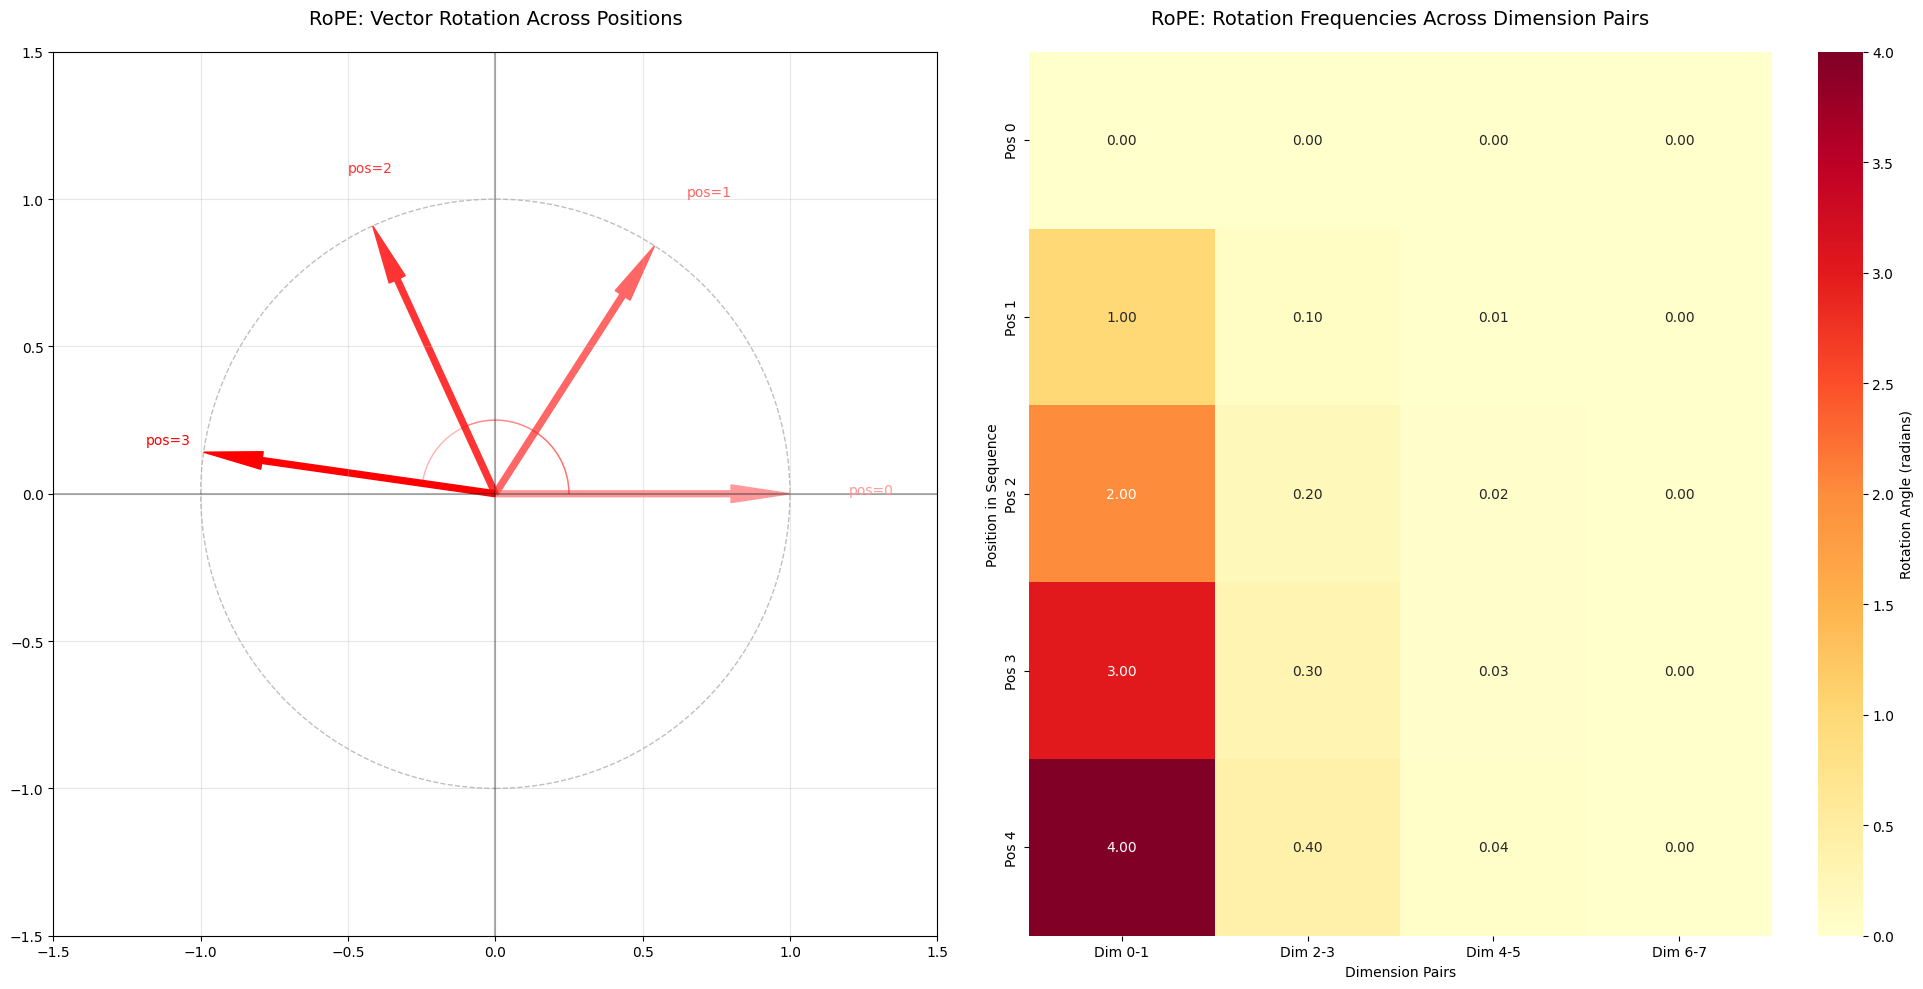

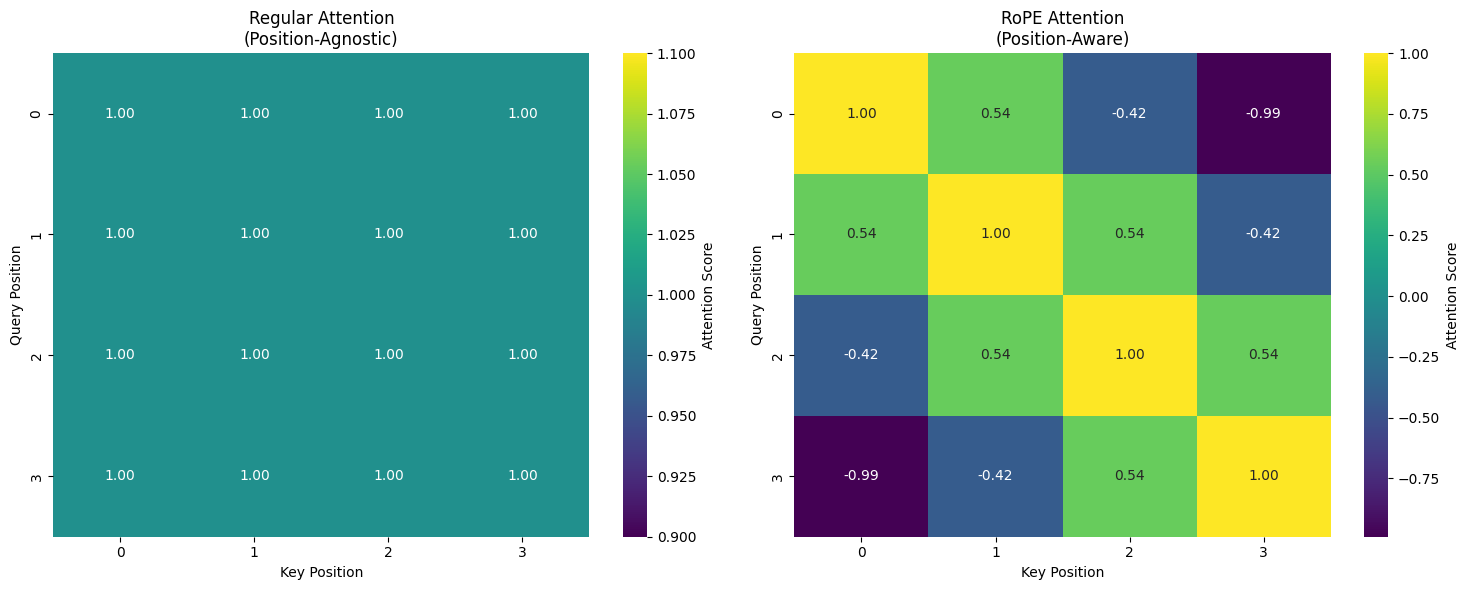

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Arrow
import seaborn as sns

def create_clear_rope_demo():
    # Set up the figure with a larger size and white background
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 10))

    # 1. Vector Rotation Demonstration
    ax1 = plt.subplot(121)
    ax1.set_title('RoPE: Vector Rotation Across Positions', pad=20, size=14)

    # Setup circular plot
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5)
    ax1.add_artist(circle)
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', alpha=0.3)
    ax1.axvline(x=0, color='k', alpha=0.3)

    # Draw vectors for different positions
    colors = ['#FF9999', '#FF6666', '#FF3333', '#FF0000']
    positions = [0, 1, 2, 3]
    base = 10000
    dim = 0  # Demonstrating rotation for first dimension pair

    for i, pos in enumerate(positions):
        # Calculate rotation angle
        theta = pos / (base ** (dim/64))  # Using smaller d_model for demonstration
        x = np.cos(theta)
        y = np.sin(theta)

        # Draw vector
        arrow = Arrow(0, 0, x, y, width=0.1, color=colors[i])
        ax1.add_patch(arrow)

        # Add position label
        ax1.text(x*1.2, y*1.2, f'pos={pos}', color=colors[i])

        # Draw arc for angle
        if i > 0:
            arc = Arc((0, 0), 0.5, 0.5,
                     theta1=0,
                     theta2=np.degrees(theta),
                     color=colors[i], alpha=0.3)
            ax1.add_patch(arc)

    ax1.set_aspect('equal')

    # 2. Frequency Variation Across Dimensions
    ax2 = plt.subplot(122)
    ax2.set_title('RoPE: Rotation Frequencies Across Dimension Pairs', pad=20, size=14)

    # Create dimension pairs
    d_model = 8
    positions = np.arange(5)
    dim_pairs = np.arange(d_model//2)

    # Calculate rotation angles for each position and dimension pair
    angles = np.zeros((len(positions), len(dim_pairs)))
    for pos in positions:
        for dim in dim_pairs:
            angles[pos, dim] = pos / (base ** (2*dim/d_model))

    # Create heatmap
    sns.heatmap(angles,
                cmap='YlOrRd',
                xticklabels=[f'Dim {2*i}-{2*i+1}' for i in range(d_model//2)],
                yticklabels=[f'Pos {i}' for i in positions],
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Rotation Angle (radians)'},
                ax=ax2)

    ax2.set_xlabel('Dimension Pairs')
    ax2.set_ylabel('Position in Sequence')

    plt.tight_layout()
    plt.show()

    # Additional explanation plot: How RoPE affects attention
    plt.figure(figsize=(15, 6))

    # Create sample query and key vectors
    positions = np.arange(4)
    queries = np.ones((4, 2))  # Simple 2D vectors
    keys = np.ones((4, 2))

    # Calculate attention scores with and without RoPE
    attention_regular = np.zeros((4, 4))
    attention_rope = np.zeros((4, 4))

    for i in positions:
        for j in positions:
            # Regular attention
            attention_regular[i, j] = 1  # All ones due to identical vectors

            # RoPE attention
            theta_diff = (i-j) / (base ** (0/64))
            attention_rope[i, j] = np.cos(theta_diff)  # Shows position-dependent attention

    # Plot attention patterns
    plt.subplot(121)
    sns.heatmap(attention_regular,
                cmap='viridis',
                xticklabels=positions,
                yticklabels=positions,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Attention Score'})
    plt.title('Regular Attention\n(Position-Agnostic)')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')

    plt.subplot(122)
    sns.heatmap(attention_rope,
                cmap='viridis',
                xticklabels=positions,
                yticklabels=positions,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Attention Score'})
    plt.title('RoPE Attention\n(Position-Aware)')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')

    plt.tight_layout()
    plt.show()

# Run the demonstration
create_clear_rope_demo()

#### Acknowledgements

This notebook is heavily adapted from a number of incredible resources on Transformers, including but not limited to:

- https://blog.floydhub.com/the-transformer-in-pytorch/
- https://arxiv.org/pdf/1706.03762.pdf
- https://txt.cohere.com/what-are-transformer-models/
- https://jalammar.github.io/illustrated-transformer/